# COMPSCI 389: Introduction to Machine Learning
# PyTorch and Overfitting

This notebook provides an introduction to Pytorch, and discusses the phenomenon of **overfitting**. So far we have covered the use of autograd to automatically differentiate Python functions. While autograd is a powerful tool, it can be quite slow. Since training ML models can be computationally intensive, using autograd for even medium-sized models may be too slow.

Other libraries have been developed specifically for automatic differentiation for ML. Two of the most popular libraries are [PyTorch](https://pytorch.org/) and [Tensorflow](https://www.tensorflow.org/). Tensorflow is a product of Google, and integrates nicely with Google's cloud computing platforms. However, it has a steeper learning curve and more verbose syntax. PyTorch is currently more commonly used ([here](https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=tensorflow,pytorch&hl=en) is a comparison using Google Trends). Other altnernatives include [Keras](https://keras.io/), [Caffe](https://caffe.berkeleyvision.org/), and [MXNet](https://mxnet.apache.org/versions/1.9.1/). In this course, we will use PyTorch. 

PyTorch (and other deep learning libraries) provides a few benefits over autograd:

1. It is highly optimized. Whereas autograd executed Python code, PyTorch relies on lower-level compiled implementations of the functions necessary to implement and train artificial neural network models.
2. It was designed for training artificial neural networks.
    - It includes default implementations of standard layers. For example, you can use high-level scripting languages to add convolutional layers, pooling layers, and fully connected layers. You can also select between pre-defined common loss functions and activation functions.

You can install PyTorch with:

> pip install torch torchvision

We will use the following imports:

In [1]:
# New to this topic:
import torch
import torch.nn as nn           # For defining our neural network model
import torch.optim as optim     # For training the model using data
from torch.utils.data import TensorDataset, DataLoader  # For making mini-batches

# From before:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Defining a network architecture (parametric model) in PyTorch

Neural network architectures (parametric models) are represented as subclasses that extend `nn.Module` (the base class for all neural network modules in PyTorch). `nn.Module` provides a range of built in functionalities, such as keeping track of trainable parameters, moving parameters and buffers to the GPU for GPU acceleration (more on this later!), saving and loading models, and more.

To create a model, we need to define the constructor, `__init__` and a function for computing the output of the model given an input, called `forward` (since this is a forwards pass).

- `__init__`: Inside of the constructor, we specify the structure of the parametric model. We do this by defining the different layers that will be used, their sizes, and the different activation functions that will be used.
- `forward`: Inside of the forward function, we specify how the different layers are ordered and where the activation functions are applied.

We do not need to specify any derivatives or anything about the backwards pass - this is all automatic!

We will create a network with three hidden layers. This network is bigger than what is needed for the GPA prediction problem. We are using a relatively large network to better show the advantages of training on a GPU and to show something called "overfitting" later.

In [2]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        # First call the nn.Module constructor to initialize other parts of the model. Always do this first.
        super(FullyConnectedNetwork, self).__init__()

        # Define layers. The lines below create the layers (memory is allocated for the weights here).
        self.fc1 = nn.Linear(9, 1024)  # First hidden layer with 1024 neurons and 9 inputs.
        self.fc2 = nn.Linear(1024, 512) # Second hidden layer with 512 neurons and 1024 inputs.
        self.fc3 = nn.Linear(512, 128)  # Third hidden layer with 128 neurons and 512 inputs.
        self.fc4 = nn.Linear(128, 1)   # Output layer with 1 neuron and 128 inputs.

        # Define activation function. You could skip this step and use nn.ReLU in the forward pass,
        # but that would be *slightly* less efficient. For small models it would likely be fine, but
        # it's best practice to create the activation function object once in the constructor. Note that
        # this object can be re-used any time a ReLU activation function is needed 
        # (we don't need many relu objects)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass data through the network
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)                 # No activation after the output layer
        return x

We can now create an instance of this model:

In [3]:
# Create an instance of the network
net = FullyConnectedNetwork()

# The network structure is printed as a sanity check
print(net)

FullyConnectedNetwork(
  (fc1): Linear(in_features=9, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


The `bias=True` terms indicates that each perceptron includes an extra feature that is always equal to 1 (and hence one extra weight beyond the number of outputs from the previous layer). This is what we discussed previously when we talked about appending a 1 to the columns of a data set to implement the "y-intercept" in linear regression. For perceptrons and neural networks, this extra weight is called the **bias**.

Next, let's load the GPA data, split it into training and testing, and standardize it.

In [4]:
df = pd.read_csv("https://people.cs.umass.edu/~pthomas/courses/COMPSCI_389/GPA.csv", delimiter=',') # Read GPA.csv, assuming numbers are separated by commas
#df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # This sets the min/max values from the training data (without looking at the testing)
X_test = scaler.transform(X_test)       # This uses the min/max scaling values chosen during training! (transform, not fit_transform)


PyTorch has its own objects for storing data, called PyTorch tensors. These are simply multidimensional arrays. Let's convert our data to these tensor objects. Note that the `tensor` constructor is not compatible with `pandas.Series` objects, so we call `y_train.values` and `y_test.values` to convert these to `numpy.ndarray` objects.

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train,        dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
X_test_tensor  = torch.tensor(X_test,         dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1,1)

Above, the `.view(-1,1)` on the labels reshapes the tensor. The first argument says to automatically calculate the size of the first dimension, and the second argument says taht the second dimension should be 1. Without `.view(-1,1)`, the `y_train_tensor` and `y_test_tensor` would be flat 1-dimensional tensors. The built-in MSE loss function that we use later expects a 2-dimensional tensor. The call to `.view(-1,1)` convert the 1-dimensional tensor into a 2-dimensional tensor (that happens to only have one column). Without this line, the training code below should preduce a warning pointing out that a 2-dimensional "target" (label) was expected, and that incorrect outputs could result.

Note that PyTorch does not have its own functions for reading data from CSV files, nor for performing train-test splits. It is therefore common to use Pandas, Scikit-Learn, and PyTorch together like this.

For now, we will keep the data as tensor objects. Later, we will use PyTorch's own dataset representation, `TensorDataset`, which is particularly useful when training on a GPU.

Next, let's define the loss function that we would like to minimize (the sample MSE). PyTorch has common loss functions built in, so we do not need to re-implement the loss function ourselves!

In [6]:
loss_function = nn.MSELoss()

Next, let's choose an algorithm for solving the optimization problem. There are many built in optimizers. For example, we could perform gradient descent with:

```
optimizer = optim.SGD(net.parameters(), lr=0.01)
```

Here, `lr` is the learning rate. We could also include a momentum parameter `momentum=0.9`. Other common optimizers include:

1. RMSprop: This is particularly useful for recurrent neural networks.
    ```
    optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
    ```
2. Adagrad: This is particularly useful for sparse data (data where most values are zero).
    ```
    optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01)
    ```
3. Adadelta: This does not require a learning rate parameter.
    ```
    optimizer = torch.optim.Adadelta(net.parameters())
    ```
4. AdamW: A variant of Adam that includes weight decay.
    ```
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)
    ```
5. SGD with momentum:
    ```
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    ```

We will use the Adam optimizer, which is currently the most popular optimizer for deep learning.

In [7]:
optimizer = optim.Adam(net.parameters())

Finally, we can run the training loop. For each epoch:

1. We will call `net(X_train_tensor)` to run the forward pass for each row in `X_train_tensor`.
2. We will Compute the resulting loss. This is a forward pass of the loss function, and is necessary!
3. We compute a backward pass starting from the loss function with `loss.backward()`. This computes the gradient with respect to each model parameter.
    - **Note**: Each model parameter has a `.grad` attribute storing the gradient of the loss w.r.t. that parameter. When `.backward()` is called, the gradients for each parameter are accumulated in this `.grad` attribute. That is, they are added to whatever is currently stored in `.grad`! This can be useful in more advanced architectures where gradients from different sources are combined. 
    - This also means that we need to clear the `.grad` parameter at the start of each epoch, so that we do not sum up the gradients across all epochs. This is achieved with `optimizer.zero_grad()`.
4. We update the weights using the optimizer via `optimizer.step()`

In [8]:
epochs = 100                    # The number of epochs to run
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = net(X_train_tensor)

    # Compute loss
    loss = loss_function(y_pred, y_train_tensor)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # Print statistics
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/100], Loss: 8.3453
Epoch [10/100], Loss: 1.4491
Epoch [20/100], Loss: 0.8890
Epoch [30/100], Loss: 0.7326
Epoch [40/100], Loss: 0.7181
Epoch [50/100], Loss: 0.6600
Epoch [60/100], Loss: 0.6356
Epoch [70/100], Loss: 0.6110
Epoch [80/100], Loss: 0.5917
Epoch [90/100], Loss: 0.5783


On my desktop, this took 32.7 seconds. We will revisit this later.

We can then evaluate the learned model on the testing data. When we do this, we do not need to store the gradient information used for training, so we wrap the code in:
```
with torch.no_grad():
    ...
```
This tells PyTorch that when running the model, it doesn't need to store information during the forward passes. Rather, we will only be using the output of the parametric model.

In [9]:
# Evaluate the model with test data
with torch.no_grad():
    y_pred_test = net(X_test_tensor)
    test_loss = loss_function(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.5853


Notice:
1. This may be slower than training the linear parametric model. That isn't because PyTorch is slower than AutoGrad, but rather because we're training a significantly more complex model.
2. This was running on the CPU. PyTorch automatically uses multithreading, so it used all of the available cores during training.

### Training ML Models on the GPU

For such a small model, training on the CPU is sufficient. For bigger models and data sets, you may want to train on the GPU. In class we will discuss the benefits of training ML models on the GPU. PyTorch makes training on the GPU relatively simple. We simply need to:

1. Install CUDA. You can download the "CUDA Toolkit" from NVIDIA [here](https://developer.nvidia.com/cuda-toolkit). Before doing so, look at the versions of CUDA that PyTorch supports using the link in the next instruction. Right now, the latest version is CUDA 12.1, which you can download [here](https://developer.nvidia.com/cuda-12-1-0-download-archive).
2. Confirm that your PyTorch installation is compatible with your version of CUDA. You can get the appropriate PyTorch installation commands for your version of CUDA [here](https://pytorch.org/get-started/locally/). For example, if you want PyTorch 2.2.1 on Windows, installed using pip, and using Cuda 12.1, the installation command is:
    > pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
3. In the code:
    - Check if CUDA (GPU support) is available.
        > device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    - Move the network to the GPU.
        > net.to(device)
    - Move the training data to the GPU.
        > X_train_tensor = X_train_tensor.to(device)
        
        > y_train_tensor = y_train_tensor.to(device)
    - When we are done training the model, we can then move it back to the CPU:
        > net.to('cpu')

We can do all of this with the following lines:

In [10]:
net = FullyConnectedNetwork()               # Create a new network to train from scratch
optimizer = optim.Adam(net.parameters())    # Create the optimizer for this network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # Check if CUDA (GPU) available
display(device)                             # Confirm that the GPU is being used

net.to(device)                              # Move the network to GPU if available
X_train_tensor = X_train_tensor.to(device)  # Also move the tensors to the chosen device
y_train_tensor = y_train_tensor.to(device)

epochs = 100                                # Number of epochs
for epoch in range(epochs):
    optimizer.zero_grad()                   # Zero the gradients
    y_pred = net(X_train_tensor)            # Forward pass
    loss = loss_function(y_pred, y_train_tensor)    # Compute the loss for printing/plotting
    loss.backward()                         # Backwards pass
    optimizer.step()                        # Update the weights using the optimizer
    if epoch % 10 == 0:                     # Print statistics
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

net.to('cpu');                              # Move the model back to the CPU

device(type='cuda')

Epoch [0/100], Loss: 8.6576
Epoch [10/100], Loss: 1.3355
Epoch [20/100], Loss: 1.0290
Epoch [30/100], Loss: 0.7493
Epoch [40/100], Loss: 0.7279
Epoch [50/100], Loss: 0.6782
Epoch [60/100], Loss: 0.6503
Epoch [70/100], Loss: 0.6216
Epoch [80/100], Loss: 0.6011
Epoch [90/100], Loss: 0.5857


Wow, that was fast! It took 2.6 seconds (GPU/CUDA) rather than more than 32.7 seconds (CPU)! For bigger models and data sets, this improvement can be even more extreme. In class we will discuss why it is often faster to train large ML models on the GPU. For now, let's confirm that we get a similar MSE on the testing set.

In [11]:
# Evaluate the model with test data (optional)
with torch.no_grad():
    y_pred_test = net(X_test_tensor)
    test_loss = loss_function(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.5872


## Using mini-batches

As we saw before, mini-batches can speed up optimization, resulting in better model parameters from fewer epochs. PyTorch provides a `DataLoader` class that can be used to automatically divide data into mini-batches. 

In order to use a DataLoader, we need to convert the data set into a TensorDataset. We do this with:
```
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
```

We can then create the DataLoader object with:
```
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
```

This DataLoader object is the standard method for passing data to a model that is being trained on a GPU. It simplifies a few things:
1. It provides methods for performing batching (using mini-batches).
2. It provides methods for shuffling the data
3. It can use multiple threads to prepare and send data to the model. This is useful for very large data sets.
    - This also minimizes the time that the GPU spends waiting for data to be provided.

For example, we can iterate over batches within an epoch with:
```
for X_batch, y_batch in train_loader:
```
We can then move these batches to the GPU with:
```
X_batch, y_batch = X_batch.to(device), y_batch.to(device)
```


In [12]:
net = FullyConnectedNetwork()
optimizer = optim.Adam(net.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

epochs = 100
for epoch in range(epochs):
    total_loss = 0.0    # To sum the loss over all batches
    num_batches = 0     # A lazy way to get the number of batches: count them
    for X_batch, y_batch in train_loader:                           # Iterate over mini-batches
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)   # Move batches to GPU
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_function(y_pred, y_batch)
        total_loss += loss.item()
        num_batches += 1
        loss.backward()
        optimizer.step()

    # Calculate the average loss over all mini-batches in this epoch
    average_loss = total_loss / num_batches

    if epoch % 10 == 0: # Print statistics
        print(f'Epoch [{epoch}/{epochs}], Average Loss: {average_loss:.4f}')
net.to('cpu');  # Move the model back to CPU if needed


Epoch [0/100], Average Loss: 0.6923
Epoch [10/100], Average Loss: 0.5668
Epoch [20/100], Average Loss: 0.5559
Epoch [30/100], Average Loss: 0.5470
Epoch [40/100], Average Loss: 0.5356
Epoch [50/100], Average Loss: 0.5185
Epoch [60/100], Average Loss: 0.4981
Epoch [70/100], Average Loss: 0.4797
Epoch [80/100], Average Loss: 0.4556
Epoch [90/100], Average Loss: 0.4359


While 100 epochs took longer, far more gradient updates where performed. Notice that the training loss reached lower values in far fewer epochs. So, the "time to complete 100 epochs" is not a particularly fair metric.

Below we compute the loss on the held out testing set.

In [13]:
# Evaluate the model with test data (optional)
with torch.no_grad():
    y_pred_test = net(X_test_tensor)
    test_loss = loss_function(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.7318


Notice that the training loss was significantly lower than the testing loss. We observed this previously with the nearest neighbor methods. Let's investigate this further by plotting the training and testing loss after each epoch.

Epoch [0/100], Training Loss: 0.6952, Testing Loss: 0.5909
Epoch [10/100], Training Loss: 0.5657, Testing Loss: 0.5853
Epoch [20/100], Training Loss: 0.5565, Testing Loss: 0.6122
Epoch [30/100], Training Loss: 0.5487, Testing Loss: 0.5915
Epoch [40/100], Training Loss: 0.5362, Testing Loss: 0.6002
Epoch [50/100], Training Loss: 0.5193, Testing Loss: 0.6233
Epoch [60/100], Training Loss: 0.4986, Testing Loss: 0.6340
Epoch [70/100], Training Loss: 0.4755, Testing Loss: 0.6614
Epoch [80/100], Training Loss: 0.4476, Testing Loss: 0.6838
Epoch [90/100], Training Loss: 0.4200, Testing Loss: 0.7116


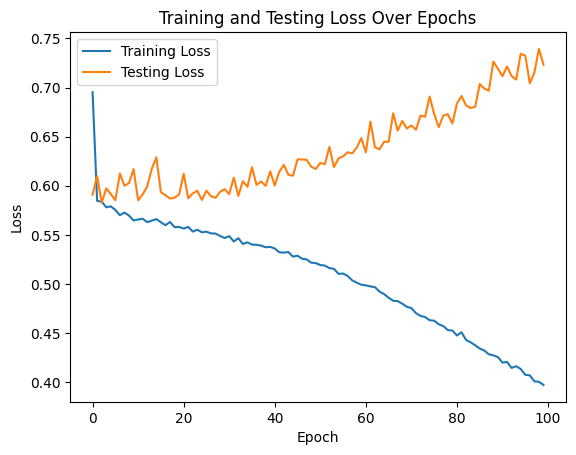

In [14]:
# Create a new network to train (the old one already had trained weights, and we want to start from scratch).
net = FullyConnectedNetwork()

# Create the optimizer for this new network
optimizer = optim.Adam(net.parameters())

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the network into GPU if available
net.to(device)

# Send the testing data to the GPU
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Convert the training and testing data to TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader to handle mini-batch loading
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

epochs = 100  # Number of epochs
training_losses = []
testing_losses = []

for epoch in range(epochs):
    net.train()  # Set the network into training mode

    # We will track the total loss across all mini-batches in this epoch
    total_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in train_loader:
        # Move batches to the same device as model
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = net(X_batch)

        # Compute loss
        loss = loss_function(y_pred, y_batch)
        total_loss += loss.item()
        num_batches += 1

        # Backward pass and update
        loss.backward()
        optimizer.step()

    # Calculate the average loss over all mini-batches in this epoch
    average_train_loss = total_loss / num_batches
    training_losses.append(average_train_loss)

    # Evaluate the model on the test data
    net.eval()  # Set the network to evaluation mode
    with torch.no_grad():
        # Forward pass on the entire test data
        y_pred_test = net(X_test_tensor)

        # Compute the loss on the entire test data
        test_loss = loss_function(y_pred_test, y_test_tensor).item()
        testing_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {average_train_loss:.4f}, Testing Loss: {test_loss:.4f}')

# Plotting the training and testing losses
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

### Overfitting

Notice that the error on the training set keeps decreasing, but the error on the testing set increases! This is a phenomenon called **overfitting**, which will be discussed in lecture. Below are some relevant plots for this discussion.

First, we plot 10 points from the line $y=x$ with Gaussian noise added:

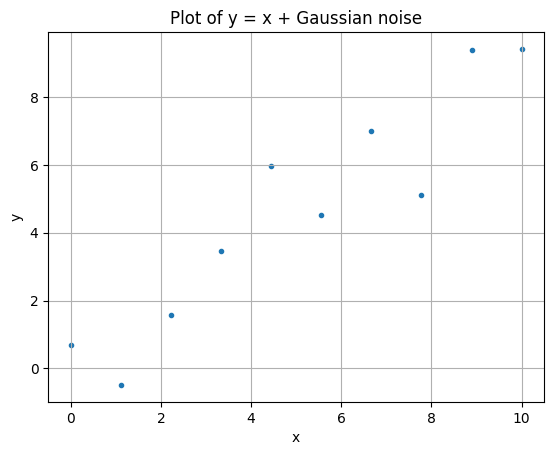

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 10)          # Generate 10 random x values
y = x + np.random.normal(0, 1, 10)  # Add noise

# Plot
plt.scatter(x, y, marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = x + Gaussian noise')
plt.grid(True)
plt.show()


Now, let's plot the least squares fit using the 10th degree Polynomial basis.

C:\Users\pthomas\AppData\Local\Temp\ipykernel_6512\3960549941.py:2: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, 10)


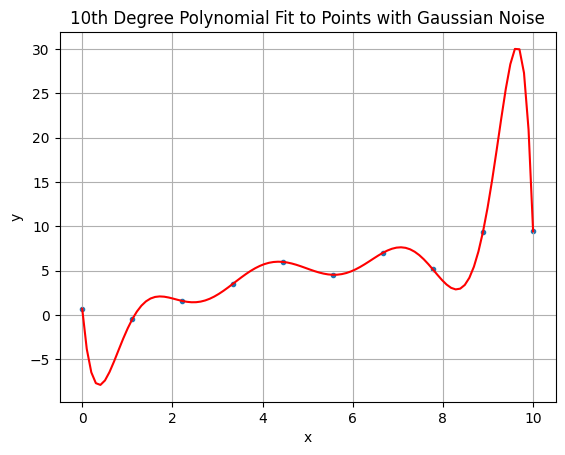

In [16]:
# Perform a least squares fit with a 10th degree polynomial basis
coefficients = np.polyfit(x, y, 10)
polynomial_fit = np.polyval(coefficients, np.linspace(0, 10, 100))

# Plotting the points as dots and the polynomial fit curve
plt.scatter(x, y, marker='.')
plt.plot(np.linspace(0, 10, 100), polynomial_fit, color='red')  # Polynomial fit curve
plt.xlabel('x')
plt.ylabel('y')
plt.title('10th Degree Polynomial Fit to Points with Gaussian Noise')
plt.grid(True)
plt.show()

This polynomial achieves a training error of zero - it goes precisely through each point! However, the test error will not be zero (remember, these are points from $y=x$ with Gausssian noise added). Here is the least squares linear fit:

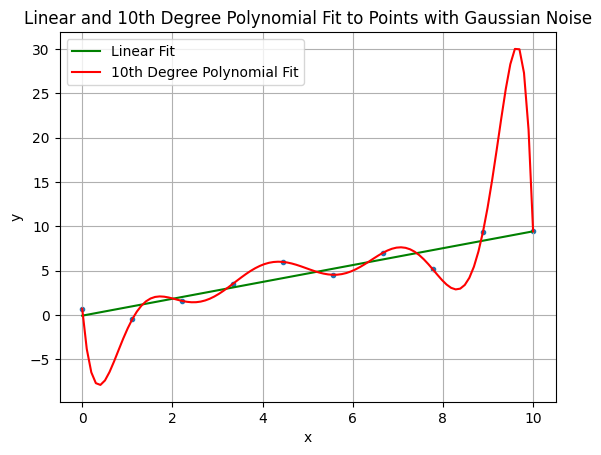

In [17]:
# Perform a linear fit (least squares)
linear_coefficients = np.polyfit(x, y, 1)
linear_fit = np.polyval(linear_coefficients, x)

# Plotting the points as dots, the linear fit, and the polynomial fit curve
plt.scatter(x, y, marker='.')
plt.plot(x, linear_fit, color='green', label='Linear Fit')  # Linear fit line
plt.plot(np.linspace(0, 10, 100), polynomial_fit, color='red', label='10th Degree Polynomial Fit')  # Polynomial fit curve
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear and 10th Degree Polynomial Fit to Points with Gaussian Noise')
plt.legend()
plt.grid(True)
plt.show()